# SLU09 - Classification with Logistic Regression: Learning notebook
This SLU introduces one of the most commonly used techniques in data science, classification. The rest of the bootcamp and some of the BLUs build on the concepts introduced here, so it's really important to spend the time to understand the details, even if it feels a bit heavy at first. Although, if you digested linear regression, this will be a breeze!

Some quick imports to get us started:

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
import utils
from sklearn.preprocessing import StandardScaler

#set plot size
plt.rcParams["figure.figsize"] = (3.5, 3.5)

#color palettes
blind_palette = sns.color_palette(palette = 'colorblind', as_cmap = True)
rb_palette = sns.color_palette(palette = 'blend:blue,red', as_cmap = True)
rb_11_palette = sns.color_palette(palette = 'blend:red,blue', n_colors = 11)

In [2]:
# Let's load the data that we will 
# use throughout this notebook

X, y = utils.get_data_iris()

## 1. Welcome to classification!
So, you just learned about regression - prediction of continuous numerical outcomes. Now it's time to tackle a different problem, classification! You could be asking:

&nbsp; &nbsp; &nbsp; _What is classification and why do I need it?_


Classification is the problem of **assigning observations to one of a finite set of classes**. We can understand classification as the answer to a simple question: 

&nbsp; &nbsp; &nbsp; _Does the example belong to a specific class or not?_

A few simple examples of classification: 
- Is it going to rain tomorrow (yes/no)? 
- Is a customer going to spend more than last month (yes/no)?
- Is a certain picture a picture of a cat or a dog (or something else)? 

You can see the pattern. What is the business or research need for doing this? Well, by being able to accurately classify a data point we can take specific actions towards it. These actions mostly aim to optimize a certain process or to influence some processes and behaviors in the future. 

For instance, an insurance company would like to predict whether a client will churn (abandon its services). If a client is classified as prone to churn, then the company could offer that client exclusive discounts or services, thus minimizing the client's odds of actually churning.

And the coolest thing... we are not stuck with a yes/no (binary) case. We can have multiclass problems - such as when you want to separate the pictures of dogs from cats and from birds - you could build a classification algorithm that learns the probability of the picture being a cat or being a dog or being a bird. We'll see later how this unfolds! 

And yes... your algorithm would certainly get confused by this:

<img src="https://qph.fs.quoracdn.net/main-qimg-8b96ea4377047d8a9c2baf20ee41f086.webp" width= "400"/>

### 1.1 Glossary
Classification has a specific terminology with many interchangeable terms due to different fields using different terms for the same things. This is an overview of the most important vocabulary so you don't get confused about what is what.

First, recall from SLU06:

- **Variable**: all values that measure the same attribute across all units (such as maximum temperature of every day). Variables are stored in columns.
- **Observation**: all values measured for the same unit across attributes (such as temperature, humidity, mm of rain on a given day). Also called a data point. Observations are stored in rows.

And new classification terminology:
- **Inputs, predictors, features, independent variables**: variables that are measured and have influence on the outputs.
- **Outputs, responses, outcomes, class labels, dependent variables**: variables that we are trying to predict.
- **Prediction model, classification model, learner**: an algorithm predicting the outputs (class labels in case of classification) based on the inputs.
- **Training dataset**:  dataset with known class labels that is used to train the model.
- **Target, ground truth**: class labels in the training dataset. These are known measured values and they are used to train the model.
- **Positive/negative**: used as class labels in binary classification. Positive class is the class we are interested in, e.g. patients with heart disease.
- **True/false**: can be used in reference to predicted values where true means that the predicted value corresponds to the target value. True can also mean something that is known to us, such as true outcomes, and true/false can be used as class labels in binary classification.

In this SLU, we will talk about **supervised classification** problems. It means that we have a dataset with known class labels - the **training dataset**. We will train our classification model on this dataset to later predict class labels for observations with the same measured variables (features), but unknown class labels. In unsupervised classification problems, we don't have a training dataset and often we don't even know the number of classes. We are predicting the class labels based on the distribution of the observations in the variable space (e.g. nearest neighbor clustering algorithms).

### 1.2 A short introduction to botany: exploring our dataset
In this learning notebook, you will find yourself in the skin of a young up-and-coming botanist, fresh out of college. You are facing the task of finding an efficient and quick method to separate three species of Iris plants based on the characteristics of the flower. In particular, you have the measurements of the width and length of sepals and petals (see illustration below). With your statistics class still fresh in your mind you know you've got the tools for the job!

These are our protagonists:

<img src="media/iris_2.png">

The first thing we do? **Explore our dataset!** We have the sepal and petal measurements in centimeters - the **features** - in the `X` dataframe and the **class labels** in the `y` series.

In [3]:
X.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


We have 50 specimens of each class and the classes are encoded as integers:
- 0 is for Iris Setosa
- 1 is for Iris Versicolour
- 2 is for Iris Virginica

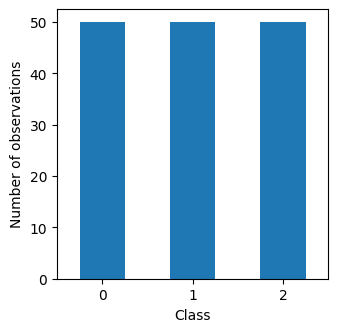

In [4]:
y.value_counts().plot.bar(rot = 0);
plt.xlabel('Class');
plt.ylabel('Number of observations');

To get an overview, we will plot the scatterplots for every pair of features. It will give us a first idea about which features are suitable to discern the three Iris species. We will use the cool [seaborn pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) for this.

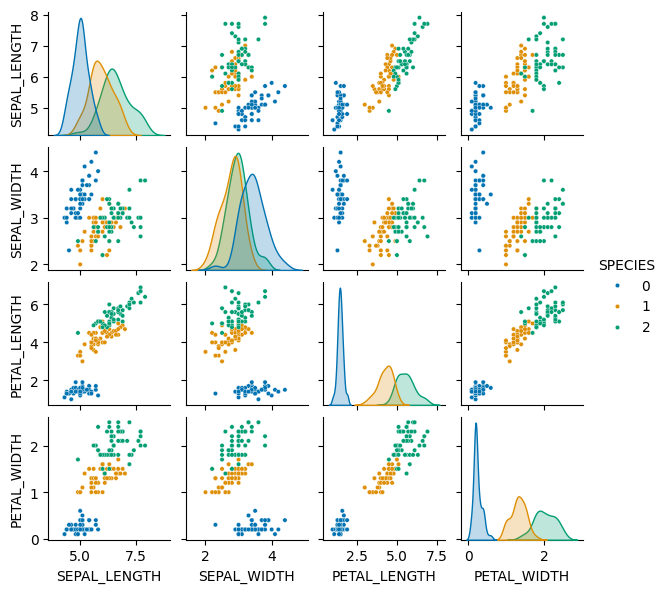

In [5]:
sns.pairplot(pd.concat((X,y), axis = 1), hue = 'SPECIES', palette = 'colorblind',
             height = 1.5, plot_kws = {"s": 10});

We see that species 0, Setosa, shown in blue, is well separated from the other two in petal length and petal width. To start simple, we will try to separate Setosa from the other two species based on petal width - a **binary classification with one variable**.

## 2. Logistic regression
Let's start with plotting the petal width for each species. The plot confirms a clear gap between Setosa (0) and the other two species.

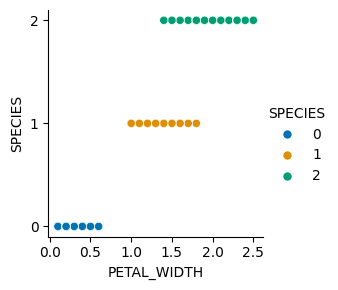

In [6]:
data = pd.concat((X[['PETAL_WIDTH']], y), axis = 1)
g = sns.relplot(x = "PETAL_WIDTH", y = "SPECIES", data = data, hue = "SPECIES",
              height = 3, markers = ".", palette = 'colorblind');
g.set(xticks = [0, 0.5, 1, 1.5, 2, 2.5]);
g.set(yticks = [0, 1, 2]);

Here we replot the same, but with two classes - Setosa as 1, and Versicolor and Virginica as 0:

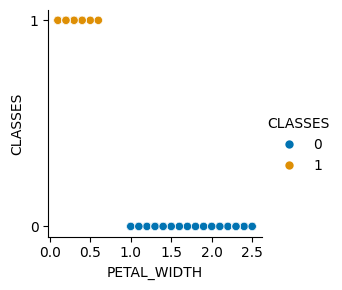

In [7]:
data = pd.concat((X[['PETAL_WIDTH']], y), axis = 1)
data['CLASSES'] = np.where(data.SPECIES == 0, 1, 0)
g = sns.relplot(x = "PETAL_WIDTH", y = "CLASSES", data = data, hue = "CLASSES",
              height = 3, markers = ".", palette = 'colorblind');
g.set(xticks = [0, 0.5, 1, 1.5, 2, 2.5]);
g.set(yticks = [0, 1]);

It's so clear, we only need to draw a line separating the species, the **decision boundary**, at petal width of about 0.8:

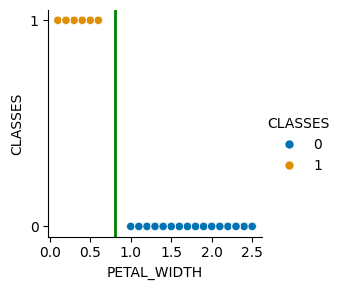

In [8]:
data = pd.concat((X[['PETAL_WIDTH']], y), axis = 1)
data['CLASSES'] = np.where(data.SPECIES == 0, 1, 0)
g = sns.relplot(x= "PETAL_WIDTH", y = "CLASSES", data = data, hue = "CLASSES",
                height = 3, markers = ".", palette = 'colorblind');
g.set(xticks = [0, 0.5, 1, 1.5, 2, 2.5]);
g.set(yticks = [0, 1]);
g.axes[0][0].axvline(x = 0.8, color = 'green', linewidth = 2);

 If you think that this is not a very scientific method to determine boundaries between classes, you are right. After all, we're aspiring data scientists, so let's live up to the expectations!

So here is what we're going to do: find a function that describes the **probability** of each data point belonging to one of the classes, say class 1, Setosa (and as this is a binary situation, not belonging to the other class, class 0, Versicolor + Virginica). The function value should be kind of like a step - its value should stay close to 0 for Versicolor and Virginica petal width values, then very quickly change to 1 for Setosa petal width values. Ideally, the function should be smooth and easy to deal with mathematically, so the [step function](https://en.wikipedia.org/wiki/Heaviside_step_function) is not a good choice.

### 2.1 The logistic function
The [**logistic function**](https://en.wikipedia.org/wiki/Logistic_regression#Definition_of_the_logistic_function) (also called sigmoid) turns out to be a good option. The classification method using the logistic function is conveniently called logistic regression.
It would be valid to ask why do they call it a ‘regression’ (which we know is a measure of the functional relationship between two or more variables) when in fact it is a classification algorithm. The name is not altogether wrong though. The algorithm predicts the probability of a data point belonging to a class, which is a continuous numerical value (hence regression), then sets a decision boundary between the classes, usually at probability = 0.5.

Here is the logistic function formula
$$ y = \frac{1}{1 + e^{-z}} $$
and plot:

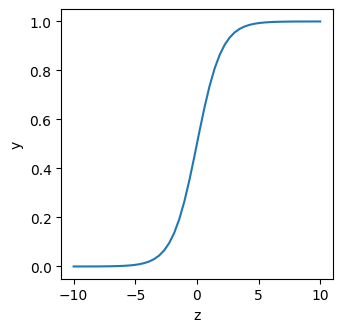

In [9]:
z = np.linspace(-10, 10)
logit = 1/(1 + np.exp(-z))
plt.plot(z, logit);
plt.xlabel('z');
plt.ylabel('y');

The logistic function has the great advantage of being limited to values in [0,1], the same range as probabilities. If we wish the values to instead go from 1 to 0, we simply invert the sign of the parameter z (i.e. the -z becomes z).

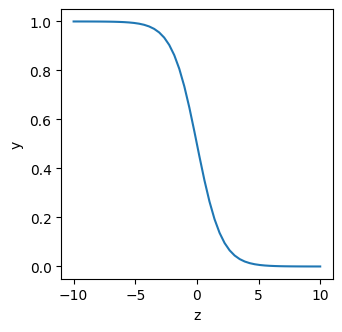

In [10]:
z = np.linspace(-10, 10)
logit = 1/(1 + np.exp(z))
plt.plot(z, logit);
plt.xlabel('z');
plt.ylabel('y');

Now how do we plug the features into this model? The parameter `z` is a **linear combination of the features**. For our binary case with one variable we get the logistic regression formula $$ \hat{p} = \frac{1}{1\ +\ e^{-(\beta_0\ +\ \beta_1\ *\ petal\_width)}} $$


$\hat{p}$ is the **estimated probability** and $\beta_0$ and $\beta_1$ are the **parameters of the model** that we need to find.

Logistic classification is a **linear classification** method, meaning that the class **decision boundaries are linear**. A picture is worth a thousand words here - see a linear decision boundary on the left and a nonlinear on the right: <img src="media/boundary_linear_nonlinear.png" width="600"/>

### 2.2 Binary univariate logistic classification
Let's get our botanist shirt on again! Now that we have new knowledge let's use it to decide between Setosas and Versicolors + Virginicas:

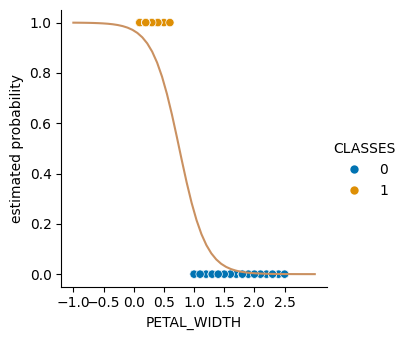

In [11]:
logit_binary = utils.binary_univariate(X, y)

How cool is this? 

Now all the values on the y-axis are between 0 and 1 - exactly the range of values we expect a probability to have.

And look at the shape! Exactly how we humans think about probability. Imagine: as soon as you move 1 cm in petal width you start to be more confident that the Iris is not a Setosa (class = 1).

The **parameters of our logistic regression model** are $\beta_0 = 3.42$ and $\beta_1 = -4.53$ (rounded to two decimals). The parameters were calculated by fitting our model to the data (more on that later).

We can now calculate the **probability of being Setosa** for Iris samples with different petal widths.

For petal width = 1.5 cm we get the probability $$ \hat{p}_{(1.5 cm)} = \frac{1}{1 + e^{-(3.42 - 4.53 * 1.5 )}} $$ 

which is 0.033, so 3.3%. By looking at the plot, it makes total sense. Plants with larger petal width are less likely to be Setosas.

We want to set the decision boundary where the logistic function equals 0.5 (50% probability of each class).

<img src="media/50percent.jpg"  width="400"/>

So for our model:
 $$ \hat{p} = 0.5 = \frac{1}{1 + e^{-(3.42 - 4.53 * petal\_width)}} $$
 
From this, we can calculate the exact and scientific value of the petal width at decision boundary as $-\beta_0/\beta_1$ which gives us a petal width of 0.75 cm:

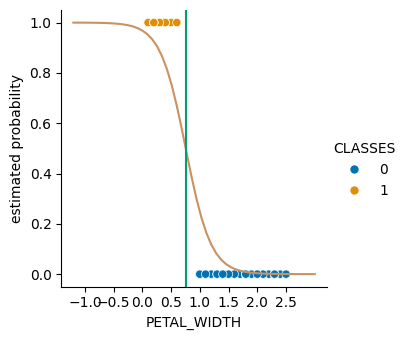

In [12]:
utils.binary_univariate_boundary(X, y, logit_binary)

Look at how the probability estimate changes along the logistic curve and the corresponding petal widths:

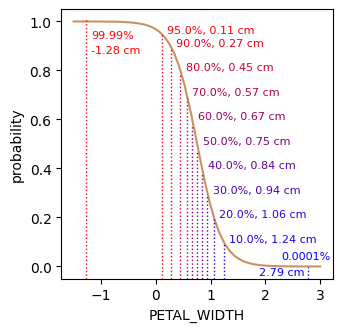

In [13]:
utils.binary_univariate_probability(logit_binary)

### 2.3 Setting decision boundaries
Above, we have set the decision boundary at $\hat{p}$ = 0.5. This is what classification algorithms use by default. However, **the threshold probability can be changed if we have a good reason** for it.

In some contexts, the decision boundaries have direct influence on business decisions. In some cases, the **cost of misclassifying 1's is low** (for example, sending a marketing e-mail to a customer that is not interested in the promoted product), so using a **more relaxed decision boundary at a lower probability** is a good choice. In other cases, the **cost of classifying some examples as 1 may be harmful** to the business (for example, classifying a bank customer as high-risk when they do not show risky behavior), so it makes sense to use a **stricter boundary at higher probabilities**, where we have higher confidence in the outcome.

The structure of the dataset can influence the decision boundaries. For instance, in the case of imbalanced classes (i.e. when two classes have a different number of observations) the boundary shifts towards the less frequent class. In other words, when using an unbalanced data set the model will think the probability of the less frequent class is lower. Our first classification example was in fact a **case of imbalanced classes**. We had 50 datapoints for the Setosa class and 100 for the Versicolor + Virginica class. We will now balance the classes by duplicating the Setosa datapoints and repeat the classification.

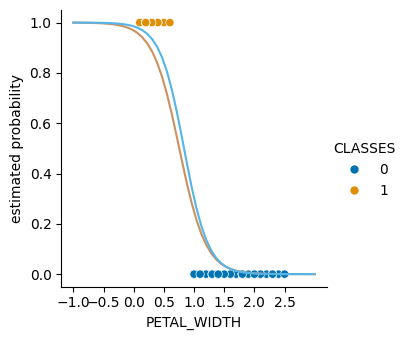

In [14]:
logit_binary, logit_balanced = utils.binary_univariate_balanced(X, y)

The reddish curve for the imbalanced classes is clearly shifted to the left compared to the lightblue curve for the balanced classes. Let's look at the model parameters:

In [15]:
print(f'The parameters for the imbalanced model are beta0 = {logit_binary.intercept_[0]:0.2f} \
and beta1 = {logit_binary.coef_[0][0]:0.2f}.') 
print(f'The parameters for the balanced model are beta0 = {logit_balanced.intercept_[0]:0.2f} \
and beta1 = {logit_balanced.coef_[0][0]:0.2f}.')

The parameters for the imbalanced model are beta0 = 3.42 and beta1 = -4.53.
The parameters for the balanced model are beta0 = 4.19 and beta1 = -5.03.


And the decision boundaries:

In [16]:
boundary_imbalanced = -logit_binary.intercept_[0] / logit_binary.coef_[0][0]
boundary_balanced = -logit_balanced.intercept_[0] / logit_balanced.coef_[0][0]
print(f"The decision boundary for the imbalanced classes is at {boundary_imbalanced:0.2f} cm petal width.")
print(f"The decision boundary for the balanced classes is at {boundary_balanced:0.2f} cm petal width.")

The decision boundary for the imbalanced classes is at 0.75 cm petal width.
The decision boundary for the balanced classes is at 0.83 cm petal width.


More information about imbalanced classes and techniques how to deal with them comes in SLU14.

### 2.4 A closer look at the logistic regression formula
We have the formula for the estimated probability $\hat{p}$ of a specific Iris sample belonging to the Setosa class. We'll be considering the balanced class model and a decision boundary at $\hat{p}$ = 0.5. Recall the formula: $$ \hat{p} = \frac{1}{1\ +\ e^{-(\beta_0\ +\ \beta_1\ *\ petal\_width)}} $$

Consider an Iris sample with petal width $a$. The exponent in the estimated probability formula will take the value $\beta_0 + \beta_1 * a$. Depending on the magnitude of $a$, there are three possibilities:

* the Iris sample belongs to the Setosa class (positive class). $\beta_0 + \beta_1 * a$ will be **positive**, lying somewhere in (0, $\infty)$. The **estimated probability will be in (0.5, 1]**. 
The higher the magnitude of $\hat{p}$ the greater is the distance between the data point and the decision boundary and therefore the higher the probability it belongs to the positive class. The Iris sample with petal width 0.3 cm belongs to this class:  $\beta_0 + \beta_1 * a$ = 2.68 and $\hat{p}$ = 0.94.

* the Iris sample belongs to the Versicolor + Virginica class (negative class). Now, $\beta_0 + \beta_1 * a$ will be **negative**, lying in $(-\infty, 0)$. But like in the positive case, the higher the absolute value, the greater the probability that $a$ belongs to the negative class. $\hat{p}$ **will now lie in \[0, 0.5)**. The Iris sample with petal width 1 cm belongs here: $\beta_0 + \beta_1 * a$ = -0.84 and $\hat{p}$ = 0.30.

* $a$ lies on the decision boundary. In this case,  $\beta_0 + \beta_1 * a = 0$. This means that we cannot say whether $a$ belongs to the positive or the negative class. As a result, $\hat{p}$ will be exactly $0.5$. Such an Iris sample would have a petal width of 0.83 cm.

### 2.5 Odds ratio
There's a way to formulate logistic regression in terms of odds ratios. For the binary univariate classification the formula can be rearranged like this: 
$$ln\left ( \frac{\hat{p}}{1-\hat{p}} \right ) = \beta_0 + \beta_1 * petal\_width $$
The $\frac{\hat{p}}{1-\hat{p}}$ function is called the **odds ratio** function **OR(X)**. In general, odds ratio is a ratio of two probabilities. Odds ratio is often used in medical research when comparing the probability of a certain event for two groups, for instance the probability of heart disease between people who exercise and those who don't. An odds ratio of 0.5 means that the incidence of heart disease in the exercising group is half as likely as the non-exercising group.

In the binary classification case, the odds ratio expresses the ratio of probabilities of an observation belonging to the positive and the negative class. Probability and odds ratio convey the exact same information, but as p ranges \[0,1\], OR(X) ranges (0, $\infty$). At the decision boundary, the probability is 0.5 and OR is 1.

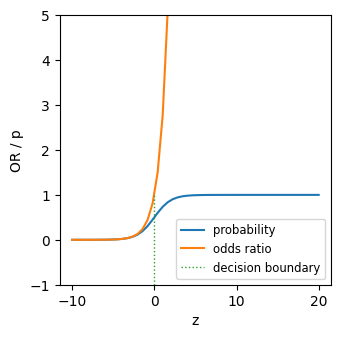

In [17]:
utils.plot_odds_ratio()

### 2.6 Multivariate logistic regression
We're going to take this up a notch. You managed to separate Setosas from the rest - but now you want to separate Versicolors from Virginicas. You know that petal and sepal width might help you. This is **multivariate binary classification** - multiple variables (2) and two classes. 

You plot both variables to understand the relationship with the target. The classes are 0 for Versicolors and 1 for Virginica:

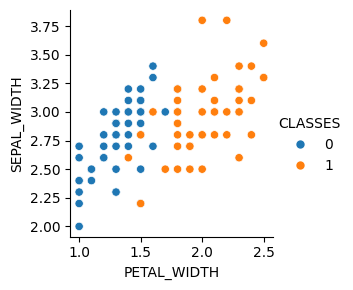

In [18]:
data = pd.concat((X, y), axis = 1)
data = data.loc[data.SPECIES != 0]
data['CLASSES'] = np.where(data.SPECIES == 2, 1, 0)
sns.relplot(x = "PETAL_WIDTH", y = "SEPAL_WIDTH", data = data, hue = "CLASSES", height = 3);

This looks like a 2D plot, but it is actually a 3D plot - two dimensions for variables, sepal and petal width, and one for classes. The third dimension is coded as color. It could also be plotted like this:

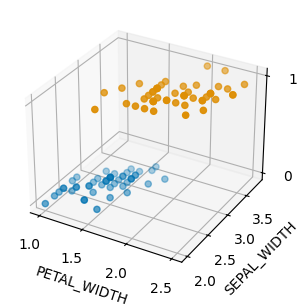

In [19]:
utils.multivariate_3d_plot(X, y)

We will use the logistic regression again, except that the **model now has two variables and three parameters**:

$$ y = \frac{1}{1\ +\ e^{-(\beta_0\ +\ \beta_1\ *\ petal\_width\ +\ \beta_2\ *\ sepal\_width)}} $$

Notice that each parameter is connected to one variable which makes the model interpretation easier. We can see how much each variable influences the model outcome.

Let's fit this model and see the parameter values:

In [20]:
y_multivariate = y[y != 0]
y_multivariate = np.where(y_multivariate == 1, 0, 1)
X_multivariate = X[['PETAL_WIDTH','SEPAL_WIDTH']][y != 0].to_numpy()
logit_multivariate = LogisticRegression(random_state = 42)
logit_multivariate.fit(X_multivariate, y_multivariate);

The parameters of the model are (in the order $\beta_0$, $\beta_1$, $\beta_2$):

In [21]:
logit_multivariate.intercept_, logit_multivariate.coef_

(array([-6.58624726]), array([[ 4.30989293, -0.19587935]]))

The shape of the probability estimate is now a 2D "logistic plane". Each probability level is a plane containing all the values of sepal and petal width having a specific probability of being an Iris Virginica. There is not a single petal and sepal width value that determines the decision boundary as in the univariate case - there is an infinite amount of sepal and petal width pairs, constituting a line. But as in the univariate case, when setting the boundary at $\hat{p}$ = 0.5, the exponent of the logistic function is 0 for each pair:

$$ \beta_0 + \beta_1 * petal\_width + \beta_2 * sepal\_width = 0$$

Rearranging, we get
$$ -\beta_0 / \beta_2 - \beta_1 / \beta_2 * petal\_width = sepal\_width$$

which is plotted below as a white line below. The probability is shown in blue (0) to red (1).

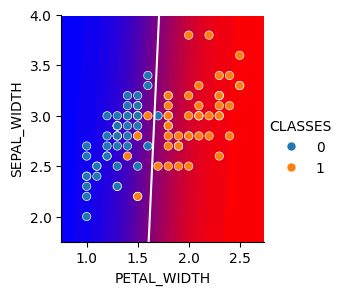

In [22]:
utils.multivariate_boundary_2d(X, y, logit_multivariate)

This plot shows the same in 3d with the boundary shown in black:

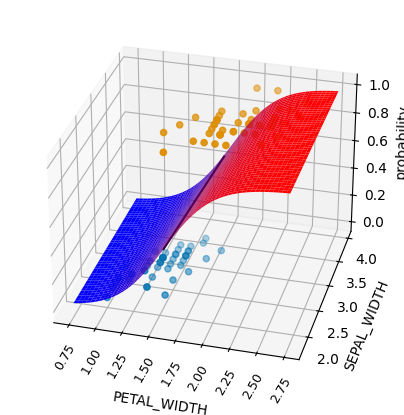

In [23]:
utils.multivariate_boundary_3d(X, y, logit_multivariate)

Before I stretch your troubled mind even further, let me take you on a trip to higher dimensions. The decision boundary for binary logistic regression with one feature was a point. With two features, it's a line. For three features, it will be a plane. For four features, it will be a three dimensional hyperplane, which is basically an infinite cube in 3d. What is it for five features? A hyperplane of four dimensions. You can imagine it like this: putting lots of points next to each other along the first dimension, you get a line. Putting lots of lines next to each other along the second dimension forms a plane and putting lots of planes next to each other along the third dimension forms a 3d space (an infinite cube). Putting lots of 3d spaces next to each other along the fourth dimension forms a 4d hyperplane. And so on. In general, the decision boundary will be a n-1 dimensional hyperplane in the feature space of n dimensions. Its equation is given by equating the exponent of the logistic function to 0, which gives the probability of 0.5 (our chosen decision boundary).

$$ \beta_0 + \beta_1 * feature_1\ +\ ...\ +\ \beta_n * feature_n= 0$$

## 3. Behind the scenes: optimization
Back to the botany lab: everything in the blue region is classified as a Versicolor and everything in the red region is a Virginica. With this solution you only misclassified 5 Iris samples - given that we have 100 samples this is an excellent classification error (you will learn more about errors and metrics in the next SLU).

Let's talk a bit about what happens behind the scenes. How does the classification algorithm find the proper decision boundary?

<img src="media/gradient_descent.jpg" width= "400"/>


Remember this? Yes, gradient descent! This was the method used to optimize linear regression. Logistic regression optimization, but also other machine learning methods, use this and a few other similar methods.

### 3.1 Maximum log-likelihood optimization
Supervised classification models need to be **trained on data with known class labels** before being used to make predictions. During the training, they learn from the data in an **iterative process** called **optimization**. 

How does the optimization process work? Similar to how humans learn new skills - by monitoring progress based on some measure of success and by taking steps in the direction of improvement, ideally by the shortest way. Imagine that you are learning to ride a bicycle. You start pedaling and at the beginning, you keep falling sideways and driving zig-zag because your balance is not great. The balance is your success measure. Gradually, you learn the right moves that improve your balance.

The success measure of an optimization process is called a **cost function or loss function**. The cost function depends on the predictions that the model made for the training data. The optimization method decides how to make the next step based on the current value of the cost function. With each step, it strives to approach the goal of finding the model that gives the best predictions for the training data. Here, most methods either **minimize or maximize the cost function**.

### 3.2 Log-likelihood cost function
The mean squared error cost function used to fit linear regression is not suitable for use with logistic regression because the prediction function is not linear. Squaring the logistic function as is done in MSE results in a non-convex function with many local minima and maxima. In such a function, it is difficult to find the global minimum or maximum.

The cost function used in logistic regression is the log-likelihood cost function. For two classes and a dataset with $N$ observations it is defined as follows, where $y_i$ are the true labels and $\hat{p}_i$ are the estimated probabilities:

$$H_{\hat{p}}(y) = \sum_{i=1}^{N} \left [ y_i \log(\hat{p}_i) + (1-y_i) \log (1-\hat{p}_i) \right ]$$

Estimated probability $\hat{p}_i(x_i,\beta)$ for each sample is given by the model we choose, so it depends on the features of the observation $x_i$ and the coefficients of the model $\beta$.

The **likelihood** gives the joint predicted probability for all the samples with the given model parameters. Our model depends on some parameters (here we call them $\beta$). For any chosen values of these parameters, the model outputs the probabilities for each sample. The likelihood is the sum of these probabilities. The higher are the probabilities, the better our model is (notice that we take the inverse of the probability for the negative class). Therefore we can use the likelihood (or the logarithm of it) as the cost function.

Note that joint probability is the product of the probabilities. It becomes a sum after taking the logarithm of it.

Let's plot the log-likelihood cost function for two different true labels $y$. The function values are all negative. When we correctly label a point, the contribution of that point to the cost function is approximately 0. As the prediction gets more and more wrong, the absolute value of the cost function slowly grows and for a completely wrong prediction, like predicting 1 instead of 0, it skyrockets.

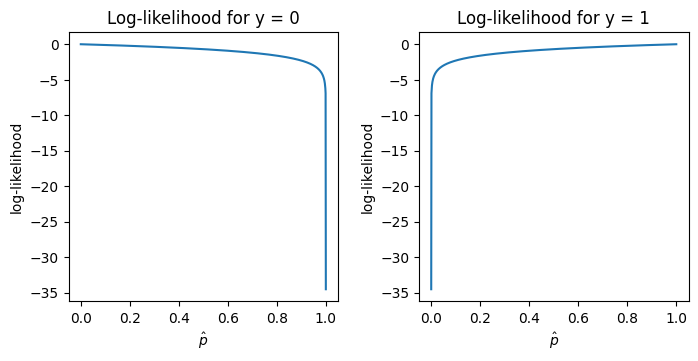

In [24]:
utils.plot_log_likelihood()

Note that $H_{\hat{p}}(y)$ depends on the model parameters $\beta$ because $\hat{p}$ depends on them. 
The optimization method used to solve the logistic regression is called **maximum log-likelihood**. The method is **maximizing the log-likelihood cost function**. In other words, it is minimizing the absolute value of this function (or minimizing the negative of the function). 

### 3.3 Optimization: finding the shortest way
The optimization problem can be described like this: we have a cost function $H_{\hat{p}}(y,\beta)$ and we would like to find its maximum (or minimum - it depends on the cost function). Imagine the cost function is like a mountainous landscape defined over the coordinates of the model coefficients $\beta$. The cost function values correspond to the altitude of the points in the landscape. In a real lanscape, each point has two coordinates, latitude and longitude. The coordinates of the cost function landscape are all the model coefficients $\beta$ - it's a landscape in a multidimensional space where the number of dimensions is determined by the number of features. The optimization problem then corresponds to finding the shortest way from the starting point to the highest peak in the landscape.

The optimization method is like a hiker that wants to get to the valley or climb a hill in fog. It is impossible to take the straightest route because the hiker can't see more than a meter in front of them. Instead, they assess the steepness of the landscape at the current position and use that information to choose the next step. It's similar to a river flowing down a mountain. It always goes down the steepest possible route and eventually gets to the lowest point ever, the ocean. See an example on the image below, with the steepness (gradient) indicated by arrows:

<img src="media/gradient_descent.png"/>

Here you can see a 1D optimization in action, looking for the function minimum:

<img src="media/gradient_descent_moving.gif" style="width: 400px;"/>

Let's look at different optimization algorithms.

#### 3.3.1 Gradient descent
The gradient descent moves along the cost function landscape in the direction of the steepest descent which we can find by using the cost function derivative, also called gradient

$$\frac{\partial H_{\hat{p}}(y,\beta)}{\partial \beta}$$ 

In each iteration, the model coefficients ($\beta$) are updated using the equation (notice the plus sign because we are going uphill):

$$\beta_{t+1} = \beta_t + learning\_rate\ \frac{\partial H_{\hat{p}}(y,\beta)}{\partial \beta_t}$$

For binary logistic regression, the equation becomes

$$\beta_{t+1} = \beta_t + learning\_rate*\sum_{i=1}^{N}  \left[ x_i \left(y_i-\hat{p}_i(x_i,\beta_t)\right) \right] $$

What we are doing here is taking the current prediction and adding the derivative of the cost function multiplied by the learning rate. This makes an uphill step along the gradient since our cost function is negative and we want to move up towards 0. (This is unlike in SLU07 where we had a positive cost function and we were subtracting the gradient, and moving downhill towards 0.)

The learning rate is a parameter that you must configure (e.g. 0.1). It influences how big a step you want to take in each iteration. Small steps converge slower, while big steps are faster but might not converge.

The gradient descent is computationally expensive for large datasets because the gradient has to be calculated for all the samples (recall that the cost function is a sum over all samples). One way to solve this problem is a variation called **stochastic gradient descent** where the gradient is calculated for a randomly selected subset of samples (it could be just one sample at a time). The trade-off is that it converges slower. A version called **stochastic average gradient descent** solves this problem and reaches the original convergence rate. It computes the gradient for just one randomly selected sample in each iteration and keeps the rest of the gradients from the previous iteration.

#### 3.3.2 Newton's method
This method uses a similar principle as the gradient descent, just smarter. It not only looks at how steep is the terrain around the current position (the first derivative), it also measures if the terrain is getting steeper or less steep. This variation of steepness is the second derivative of the cost function. The model coefficients are updated according to
$$\beta_{t+1} = \beta_t - learning\_rate\ \frac{\partial H_{\hat{p}}(y,\beta)}{\partial \beta_t}\ \left(\frac{\partial^2 H_{\hat{p}}(y,\beta)}{\partial \beta_t^2}\right)^{-1}$$
which for the binary logistic regression case becomes

$$\beta_{t+1} = \beta_t + learning\_rate * \left(\sum_{i=1}^{N} x_i\  x_i^T\  \hat{p}_i(x_i,\beta_t) \ \left(1 - \hat{p}_i(x_i,\beta_t)\right)\right) ^{-1}\ \sum_{i=1}^{N} x_i \left(y_i - \hat{p}_i(x_i,\beta_t)\right)$$

Newton's method converges faster than the gradient descent as illustrated below as the red vs. the green path from the initial position x$_0$ to the final position x. It follows a steeper route than the gradient descent. The blue lines are countour lines, the function value is constant along them. The distance between them indicates the steepness of the cost function landscape. Newton's method is also computationally more expensive because it calculates both the first and the second derivative.

<img src="media/Newton_optimization_vs_grad_descent.png" width="300"/>

#### 3.3.3 Coordinate descent
Coordinate descent is a simpler version of the gradient descent. The cost function is minimized along one coordinate (feature) at a time, i.e. the gradient is computed with respect to just one variable in each step. In our landscape analogy, it is as if the hiker makes one step uphill in the north-south direction, one step in the east-west direction, then another step in the north-south direction, and so on. The convergence is slower, but the method is less computationally expensive.

The update rule is $$\beta_{t+1,j} = \beta_{t,j} + learning\_rate \frac{\partial H_{\hat{p}}(y,\beta)}{\partial \beta_{t,j}}$$

where $j$ is the coordinate along which we descend in the current step. The values of the other coefficients are held constant. In the next step, we update the next coefficient $\beta_{j+1}$ and so on. For binary logistic regression, it becomes

$$\beta_{t+1,j} = \beta_{t,j} + learning\_rate*\sum_{i=1}^{N}  \left[ x_{i,j} \left(y_i-\hat{p}_i(x_i,\beta_t)\right) \right] $$

Here is an illustration of the path the coordinate descent takes from the initial position on the periphery to the final position at the peak. The lines are contour lines.

<img src="media/Coordinate_descent.png" width="400"/>

How interesting would it be to actually observe Logistic Regression perform the gradient descent and progressively adjust the decision boundary? Let's do just that! Let's observe 15 iterations of the stochastic average gradient descent for another example of multivariate binary classification. We have two variables here, petal width and sepal length, and two classes - Versicolor coded as 0 and Virginica coded as 1. The probability is coded in color changing from blue to red as it goes from 0 to 1. You need to run this cell to see it happen!

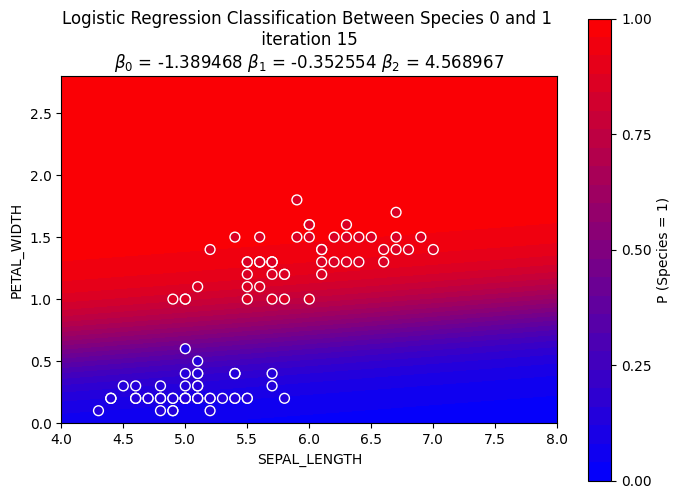

<Figure size 800x600 with 0 Axes>

In [25]:
# run this cell! it takes a bit of time, but it is nice to watch. you can change the number of iterations.
utils.gradient_descent_classification_plot(X, y, 15)

## 4. Implementation in sklearn
We've been using the sklearn implementation of logistic regression to model all the examples in this unit. Let's now explore in detail how to use it. We're almost at the end, hold on!

### 4.1 Feature scaling
The sklearn implementation uses a method called **regularization to prevent overfitting** (which basically means avoiding getting lost in details) and therefore requires standardization of variables (you will learn more about regularization and overfitting in SLUs 13 and 14). If the variance of one particular feature is orders of magnitude larger than the variance of the rest of the features, the model will be unable to learn from the other features as expected. Standardization means that **the mean of the distribution is adjusted to 0 and its variance to 1** (it is supposed that we are dealing with a "nice" distribution, at least symmetric and possibly Gaussian). The standardization is also advantageous for the optimization. The optimization is initialized by randomly choosing values around zero and if the variable values are very far from there or not symmetrical around 0, the optimization will take much longer to converge. This becomes apparent with large datasets.

To adjust your variables to zero mean and unit variance, you apply the following formula to each variable:

$$ x_{standardized} = \frac{x - mean(x)}{std(x)}$$

Some texts will refer to this as normalization, so always check what is meant by the term you encounter.

It is a simple formula and scikit-learn has this transformation already implemented as `StandardScaler`, see [here](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). This is how to use it:

In [26]:
from sklearn.preprocessing import StandardScaler

sclr = StandardScaler().fit(X)
X_standardized = sclr.transform(X)

The scaling occurs in two steps. First, with the `fit()` method, the scaler learns the mean and the standard deviation of each feature from the training data. This happens only once and always with the training data. Then, with the `transform()` method, you can scale the training or the test data with the learned mean and standard deviation. 

Now you can confidently apply logistic regression to the standardized data.

### 4.2 Logistic regression with sklearn
You now know most of what you need to know about Logistic Regression. These are its strengths and weaknesses:
* **Strengths:** 
    * Outputs have a probabilistic interpretation and can be updated easily with new data. Additionally, the algorithm can be regularized to avoid overfitting - something you will learn further ahead. The sklearn algorithm automatically uses regularization and because of that it is necessary to standardize the data to mean = 0 and variance = 1.
    * Explainable and interpretable in terms of business - you can easily extract the coefficients that show how strongly each variable influences the outcome.


* **Weaknesses:** 
    * Logistic regression is not suitable for classification problems with non-linear decision boundaries. The shape of the ideal decision boundary depends on the distribution of the data. For instance, for samples drawn from a normal distribution, linear boundaries are the best you can do and logistic regression will find them. For samples drawn from a mixture of normal distributions, linear class boundaries do not work well, so it's better to choose another classifier.

Fortunately, there are already a lot of logistic regression implementations that are quite computationally efficient. So there's no need for you to code them from scratch. You can find one of those implementations in the [sklearn Python module](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

<img src="media/touch_sklearn.jpg" width= "400"/>


Let's use it!

In [27]:
from sklearn.linear_model import LogisticRegression

This implementation can use the following optimization methods:
* lbfgs (default)
* newton-cg
* liblinear
* sag
* saga

 `Lbfgs` and `newton-cg` are variants of Newton's method, `liblinear` is a coordinate descent, and `sag` and `saga` are stochastic gradient descents. For a short overview of the solver algorithms, check this stackoverflow [post](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions).  
The `liblinear` solver can only handle binary problems. It tackles multiclass problems with the one-vs-rest strategy - it finds the probability estimate for each class against all the other classes. The other solvers can solve multiclass problems in a true multiclass fashion. The `multi-class` argument takes care of this. It is set to `auto` by default, but you can select between one-vs-rest and multiclass strategy by choosing `ovr` or `multinomial`.

`Liblinear` is a good choice for small datasets, `sag` and `saga` are faster for large datasets.

You can check the classifier parameters with the `get_params()` method.

The algorithm has a lot more arguments as well as methods that you can explore in the [API reference](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and the [user guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).

Now that you've imported the class, you need to **create the classifier object**. The `random_state` parameter is affecting the reproducibility of the results across different runs, so always set it to the same value.

In [28]:
logit_clf = LogisticRegression(random_state = 42)

Cool, you just created the classifier object that is ready to learn from your data. As we passed just one parameter, all the others are at default values:

In [29]:
logit_clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Now we give the classifier the training data `X` (the standardized version) as well as the corresponding class labels `y` so that it can train and converge to the optimal parameters. To recall the dataset:

In [30]:
df_full = pd.concat([X, y], axis = 1)
display(df_full.sample(5, random_state = 50))

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
88,5.6,3.0,4.1,1.3,1
72,6.3,2.5,4.9,1.5,1
20,5.4,3.4,1.7,0.2,0
16,5.4,3.9,1.3,0.4,0
147,6.5,3.0,5.2,2.0,2


We will use all four variables to divide Setosas from Versicolors:

In [31]:
X_standardized = X.loc[y != 2]
sclr = StandardScaler().fit(X_standardized)
X_standardized = sclr.transform(X_standardized)
logit_clf.fit(X_standardized, y[y != 2])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Et voilà! You just created your first logistic regression model. Let's look at the model coefficients:

In [32]:
logit_clf.intercept_, logit_clf.coef_

(array([0.16638974]),
 array([[ 0.82618731, -1.15824998,  1.52836551,  1.53896841]]))

The last two parameters, petal length and petal width, have slightly more influence on the outcome than the first two. Now, it would be interesting to know how good the model is. And we can do so, by checking the mean accuracy of the predictions:

In [33]:
logit_clf.score(X_standardized, y[y != 2])

1.0

Oh, we were right 100% of the time! That does not happen very often in real life. What if we want to get the predictions for each sample instead of the score?

In [34]:
preds = logit_clf.predict(X_standardized)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Great! These are the `argmax` of the predicted probabilities, in other words, the class with the highest predicted probability for each sample. However, it would be more interesting to obtain and observe the probabilities of each class:

In [35]:
probas = logit_clf.predict_proba(X_standardized)
probas[:10]

array([[0.9883498 , 0.0116502 ],
       [0.97022121, 0.02977879],
       [0.9870651 , 0.0129349 ],
       [0.98217403, 0.01782597],
       [0.99194415, 0.00805585],
       [0.98463039, 0.01536961],
       [0.98975704, 0.01024296],
       [0.98552836, 0.01447164],
       [0.97991642, 0.02008358],
       [0.98005437, 0.01994563]])

And then we can do whatever we want with the predicted probabilities (e.g. set a custom class boundary). Notice that the classifier returns the probabilities for both classes.

Let's say that instead of solving our problem by separating 2 types of flowers each time, we solved it by separating all 3 of them at the same time - just like in our original problem. This is **multiclass multivariate classification** - 3 classes and 4 variables. We will use the `sag` solver.

In [36]:
# instantiate
logit = LogisticRegression(random_state = 42, solver = 'sag')

#standardize
sclr = StandardScaler().fit(X)
X_standardized = sclr.transform(X)

# fit
logit.fit(X_standardized, y)

# predict
predictions = logit.predict(X_standardized)

# get predicted probabilities
probability_predictions = logit.predict_proba(X_standardized)

In [37]:
# display the first 5 predicted probabilities 
probability_predictions[0:5]

array([[9.84693948e-01, 1.53059904e-02, 6.19875198e-08],
       [9.43463018e-01, 5.65365941e-02, 3.87825662e-07],
       [9.82143080e-01, 1.78568320e-02, 8.82979260e-08],
       [9.75401298e-01, 2.45985175e-02, 1.84184747e-07],
       [9.91127542e-01, 8.87242476e-03, 3.29009231e-08]])

So how do we read this... The first flower is clearly a class 0, Setosa.

In [38]:
probability_predictions[0]

array([9.84693948e-01, 1.53059904e-02, 6.19875198e-08])

Let's look at another flower, the one at position 70: 

In [39]:
probability_predictions[70]

array([0.01201304, 0.44034437, 0.54764259])

Ok, so this flower: 
- is likely to be a Virginica (55% probability)
- may still be a Versicolor (44% probability) 
- is almost certainly not a Setosa (1% probability). 

And... we're done. You just learned your first classification algorithm. There will be more good things to come in SLUs 11, 18, and 19 because not all classification problems are solvable with logistic regression.

Now go on to the exercise notebook to practice!

## 5. References and further reading
1. R. A. Fisher (1936). "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188. doi:10.1111/j.1469-1809.1936.tb02137   
1. Edgar Anderson (1936). "The species problem in Iris". Annals of the Missouri Botanical Garden. 23 (3): 457–509. doi:10.2307/2394164   
1. [The elements of statistical learning](https://hastie.su.domains/ElemStatLearn/) (aka the machine learning bible)   
1. [API reference](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and the [user guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) for scikit-learn logistic regression.  
1. A short explanation of the solvers in scikit logistic regression https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions For more details, refer to the original publications linked in the user guide.   
1. Something for fun - machine learning couples with art to create beautiful images of real loss function landscapes https://losslandscape.com/
1. Images:
   - Iris setosa: CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=170298
   - Iris versicolor: Danielle Langlois in July 2005 at the Forillon National Park of Canada, Quebec, Canada
   - Iris virginica: By Frank Mayfield - originally posted to Flickr as Iris virginica shrevei BLUE FLAG, CC BY-SA 2.0, https://commons.wikimedia.org/w/index.php?curid=9805580
   - linear and non-linear decision boundaries: [The elements of statistical learning](https://hastie.su.domains/ElemStatLearn/), chapter 2
   - comparison of Newton's method and gradient descent: By Oleg Alexandrov - self-made with Matlab. Tweaked in Inkscape, Public Domain, https://commons.wikimedia.org/w/index.php?curid=2284243
   - coordinate descent: By Nicoguaro - Own work, CC BY 4.0, https://commons.wikimedia.org/w/index.php?curid=46260701